In [2]:
import keras, os, time
from __future__ import division
from __future__ import print_function
from models_def import build_mnist_model
from data import get_mnist_data
from utils import estimate_ipt_mnist, get_super_resol_A, get_inpaint_A
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import pickle
%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


## Train / Load DAE


In [3]:
autoencoder = build_mnist_model()

In [4]:
#Get data 
x_train, x_test = get_mnist_data()
#x_train_noisy = np.zeros(x_train.shape, dtype=np.float32)

#train
#x_train_noisy[:10000] = x_train[:10000] + 0.25*np.random.normal(loc=0.0, scale=1.0, size=(10000,28,28,1)) 
#x_train_noisy[10000:2*10000] = x_train[10000:2*10000] + 0.50*np.random.normal(loc=0.0, scale=1.0, size=(10000,28,28,1)) 
#x_train_noisy[2*10000:3*10000] = x_train[2*10000:3*10000] + 0.75*np.random.normal(loc=0.0, scale=1.0, size=(10000,28,28,1)) 
#x_train_noisy[3*10000:4*10000] = x_train[3*10000:4*10000] + 1.0*np.random.normal(loc=0.0, scale=1.0, size=(10000,28,28,1)) 
#x_train_noisy[4*10000:5*10000] = x_train[4*10000:5*10000] + 1.25*np.random.normal(loc=0.0, scale=1.0, size=(10000,28,28,1))

x_test_noisy = x_test + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

In [5]:
#%%capture training
#autoencoder.compile(optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error')
#autoencoder.fit(x_train_noisy, x_train,
#                epochs=100,
#                batch_size=128,
#                shuffle=True,
#                validation_data=(x_test_noisy, x_test),)
#model_json = autoencoder.to_json()
#with open("models/mnist/mnist_autoencoder_full", "w") as json_file:
#    json_file.write(model_json)
    # serialize weights to HDF5
#    autoencoder.save_weights("models/mnist/mnist_autoencoder_full_weights")
#    print("Saved model to disk")

In [6]:
#Load Model
json_file = open('models/mnist/mnist_autoencoder_full', 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder.load_weights("models/mnist/mnist_autoencoder_full_weights")
print("Loaded model from disk")

Loaded model from disk


## Test DAE on Noisy Images

In [7]:
x_preds = autoencoder.predict(x_test_noisy)

## Original Test Images

[6329 7778  183 3564 7851 5687 7674 9522 7053 6462]


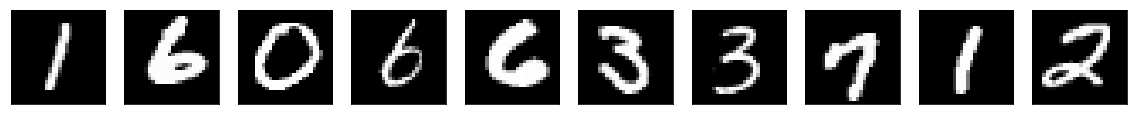

In [8]:
x_vis = np.random.choice(range(10000), size=10, replace=False)
print(x_vis)
plt.figure(figsize=(20, 2))
ctr =1
for i in x_vis:
    ax = plt.subplot(1, 10, ctr)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ctr+=1
plt.show()

## Noisy Test Images

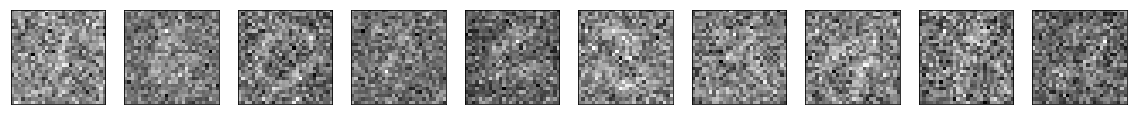

In [9]:
plt.figure(figsize=(20, 2))
ctr =1
for i in x_vis:
    ax = plt.subplot(1, 10, ctr)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ctr+=1
plt.show()

## Denoised Test Images

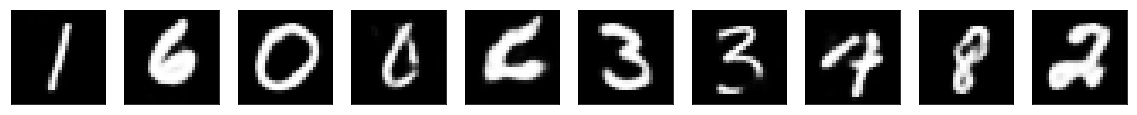

In [10]:
plt.figure(figsize=(20, 2))
ctr =1
for i in x_vis:
    ax = plt.subplot(1, 10, ctr)
    plt.imshow(x_preds[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ctr+=1
plt.show()

## Compressive Sensing: No Noise


In [10]:
x_test_task = [7986, 2369,  278, 2460, 6217, 8439, 7326, 9675, 4313,  618]

## Algorithm 1: IPT

In [11]:
results_dir = 'results/cs_no_noise/mnist/'
norm_diff = {}
time_diff = {} #turn off visualization when using measuring time comnplexity
for m in [25,50,75,100,150,200]:
    A = (np.random.normal(0, 1/np.sqrt(m), (m, 784)))
    y = np.zeros((10,m))
    ctr = 0
    for i in x_test_task:
        y[ctr] = np.dot(A, x_test[i].flatten())
        ctr+=1

    iterations = 10 
    num_test = 10
    A_T = A.T
    norm_diff[m] = num_test*[0.]
    time_diff[m] = num_test*[0.]
    print("Using m={}".format(m))
    for i in range(num_test):
        print("Test Image Name: {}.jpg".format(x_test_task[i]))
        x_est, time_diff[m][i] = estimate_ipt_mnist(A, A_T, y[i], autoencoder, iterations)
        norm_diff[m][i] = np.linalg.norm(x_est.flatten() - x_test[x_test_task[i]].flatten())
        im = Image.fromarray((x_est * 255).astype(np.uint8))
        im.save(results_dir + '{}/{}.png'.format(m,x_test_task[i]))
        
with open(results_dir + 'norm_diffs.pickle', 'wb') as handle:
    pickle.dump(norm_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(results_dir + 'time_diffs.pickle', 'wb') as handle:
    pickle.dump(time_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

Using m=25
Test Image Name: 7986.jpg
Test Image Name: 2369.jpg
Test Image Name: 278.jpg
Test Image Name: 2460.jpg
Test Image Name: 6217.jpg
Test Image Name: 8439.jpg
Test Image Name: 7326.jpg
Test Image Name: 9675.jpg
Test Image Name: 4313.jpg
Test Image Name: 618.jpg
Using m=50
Test Image Name: 7986.jpg
Test Image Name: 2369.jpg
Test Image Name: 278.jpg
Test Image Name: 2460.jpg
Test Image Name: 6217.jpg
Test Image Name: 8439.jpg
Test Image Name: 7326.jpg
Test Image Name: 9675.jpg
Test Image Name: 4313.jpg
Test Image Name: 618.jpg
Using m=75
Test Image Name: 7986.jpg
Test Image Name: 2369.jpg
Test Image Name: 278.jpg
Test Image Name: 2460.jpg
Test Image Name: 6217.jpg
Test Image Name: 8439.jpg
Test Image Name: 7326.jpg
Test Image Name: 9675.jpg
Test Image Name: 4313.jpg
Test Image Name: 618.jpg
Using m=100
Test Image Name: 7986.jpg
Test Image Name: 2369.jpg
Test Image Name: 278.jpg
Test Image Name: 2460.jpg
Test Image Name: 6217.jpg
Test Image Name: 8439.jpg
Test Image Name: 7326.jpg


## Compressive Sensing: With Noise


In [12]:
results_dir = 'results/cs_noise/mnist/'
norm_diff = {}
time_diff = {} #turn off visualization when using measuring time comnplexity
for m in [25,50,75,100,150,200]:
    A = (np.random.normal(0, 1/np.sqrt(m), (m, 784)))
    y = np.zeros((10,m))
    ctr = 0
    for i in x_test_task:
        y[ctr] = np.dot(A, x_test[i].flatten()) + np.random.normal(loc=0., scale=0.5, size=m)
        ctr+=1

    iterations = 10 
    num_test = 10
    A_T = A.T
    norm_diff[m] = num_test*[0.]
    time_diff[m] = num_test*[0.]
    print("Using m={}".format(m))
    for i in range(num_test):
        print("Test Image Name: {}.jpg".format(x_test_task[i]))
        x_est, time_diff[m][i] = estimate_ipt_mnist(A, A_T, y[i], autoencoder, iterations)
        norm_diff[m][i] = np.linalg.norm(x_est.flatten() - x_test[x_test_task[i]].flatten())
        im = Image.fromarray((x_est * 255).astype(np.uint8))
        im.save(results_dir + '{}/{}.png'.format(m,x_test_task[i]))
        
with open(results_dir + 'norm_diffs.pickle', 'wb') as handle:
    pickle.dump(norm_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(results_dir + 'time_diffs.pickle', 'wb') as handle:
    pickle.dump(time_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

Using m=25
Test Image Name: 7986.jpg
Test Image Name: 2369.jpg
Test Image Name: 278.jpg
Test Image Name: 2460.jpg
Test Image Name: 6217.jpg
Test Image Name: 8439.jpg
Test Image Name: 7326.jpg
Test Image Name: 9675.jpg
Test Image Name: 4313.jpg
Test Image Name: 618.jpg
Using m=50
Test Image Name: 7986.jpg
Test Image Name: 2369.jpg
Test Image Name: 278.jpg
Test Image Name: 2460.jpg
Test Image Name: 6217.jpg
Test Image Name: 8439.jpg
Test Image Name: 7326.jpg
Test Image Name: 9675.jpg
Test Image Name: 4313.jpg
Test Image Name: 618.jpg
Using m=75
Test Image Name: 7986.jpg
Test Image Name: 2369.jpg
Test Image Name: 278.jpg
Test Image Name: 2460.jpg
Test Image Name: 6217.jpg
Test Image Name: 8439.jpg
Test Image Name: 7326.jpg
Test Image Name: 9675.jpg
Test Image Name: 4313.jpg
Test Image Name: 618.jpg
Using m=100
Test Image Name: 7986.jpg
Test Image Name: 2369.jpg
Test Image Name: 278.jpg
Test Image Name: 2460.jpg
Test Image Name: 6217.jpg
Test Image Name: 8439.jpg
Test Image Name: 7326.jpg


## Superresolution

In [28]:
x_test_task = [5938, 3531, 4275, 9969, 2103, 3557, 8480, 5513, 9482, 2757]

In [65]:
def estimate_ipt_mnist(A, A_T, y, autoencoder, iterations, visualize=False, x=None): 
        
        if visualize and x is not None: 
            plt.figure(figsize=(20, 2))
 
        x_t = np.random.normal(0., 1, (784,))
        x_final = np.zeros((28,28,1))
        
        start_time = time.time()
        # WARNING: Visualization logic is hardcoded to the value 10, 
        #  if you change iterations , visualization logic will need to be changed too
        for j in range(iterations):
            v_t = x_t - np.dot(2.0*A_T, np.dot(A,x_t) - y)
            x_t = autoencoder.predict(v_t.reshape(1,28,28,1))
            
            if visualize and x is not None:
            #Print original image
                if j == 0:
                    ax = plt.subplot(1, 20, j / 1 + 1)
                    plt.imshow(x.reshape((28,28)))
                    plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                #Show recovered image at iteration j
                if j % int(iterations/10)== 0 and j > 1:
                    print(j)
                    ax = plt.subplot(1, 20, j/int(iterations/10) + 1)
                    plt.imshow(x_t.reshape((28,28)))
                    plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

            x_t = x_t.reshape((784,))
            if j == iterations -1:
                time_diff = time.time() - start_time #time to run 10 iterations 
                x_final = x_t.reshape((28,28))
        
        if visualize:
            plt.show() 
        
        return x_final, time_diff

Using m=2
Test Image Name: 5938.jpg
100
200
300
400
500
600
700
800
900


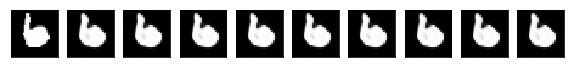

Test Image Name: 3531.jpg
100
200
300
400
500
600
700
800
900


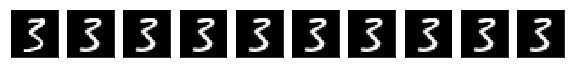

Test Image Name: 4275.jpg
100
200
300
400
500
600
700
800
900


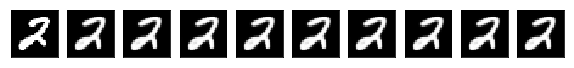

Test Image Name: 9969.jpg
100
200
300
400
500
600
700
800
900


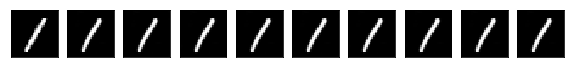

Test Image Name: 2103.jpg
100
200
300
400
500
600
700
800
900


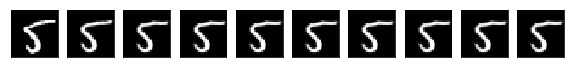

Test Image Name: 3557.jpg
100
200
300
400
500
600
700
800
900


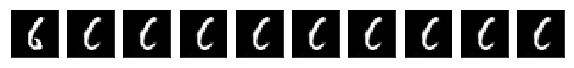

Test Image Name: 8480.jpg
100
200
300
400
500
600
700
800
900


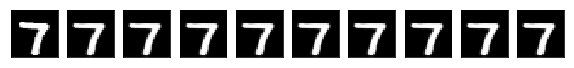

Test Image Name: 5513.jpg
100
200
300
400
500
600
700
800
900


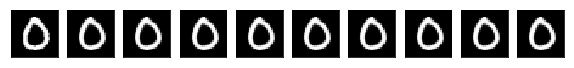

Test Image Name: 9482.jpg
100
200
300
400
500
600
700
800
900


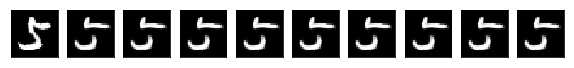

Test Image Name: 2757.jpg
100
200
300
400
500
600
700
800
900


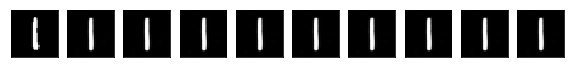

Using m=3
Test Image Name: 5938.jpg
100
200
300
400
500
600
700
800
900


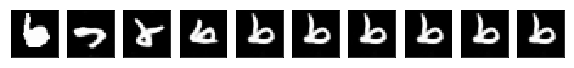

Test Image Name: 3531.jpg
100
200
300
400
500
600
700
800
900


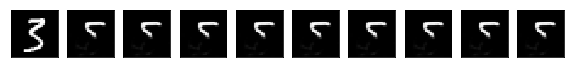

Test Image Name: 4275.jpg
100
200
300
400
500
600
700
800
900


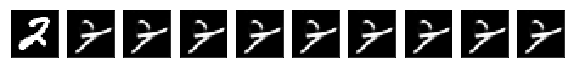

Test Image Name: 9969.jpg
100
200
300
400
500
600
700
800
900


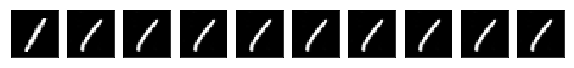

Test Image Name: 2103.jpg
100
200
300
400
500
600
700
800
900


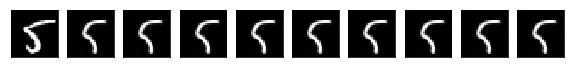

Test Image Name: 3557.jpg
100
200
300
400
500
600
700
800
900


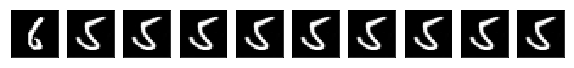

Test Image Name: 8480.jpg
100
200
300
400
500
600
700
800
900


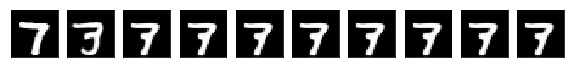

Test Image Name: 5513.jpg
100
200
300
400
500
600
700
800
900


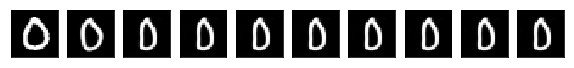

Test Image Name: 9482.jpg
100
200
300
400
500
600
700
800
900


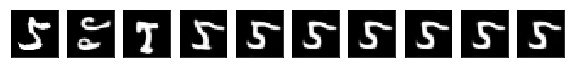

Test Image Name: 2757.jpg
100
200
300
400
500
600
700
800
900


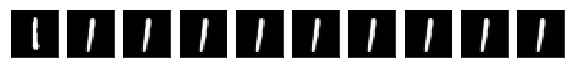

Using m=4
Test Image Name: 5938.jpg
100
200
300
400
500
600
700
800
900


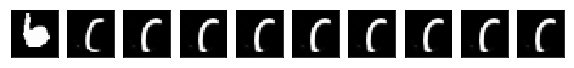

Test Image Name: 3531.jpg
100
200
300
400
500
600
700
800
900


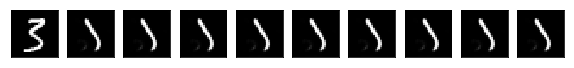

Test Image Name: 4275.jpg
100
200
300
400
500
600
700
800
900


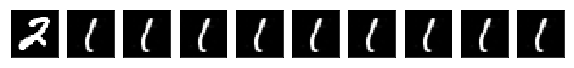

Test Image Name: 9969.jpg
100
200
300
400
500
600
700
800
900


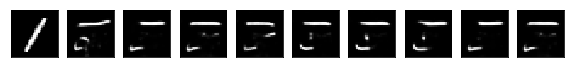

Test Image Name: 2103.jpg
100
200
300
400
500
600
700
800
900


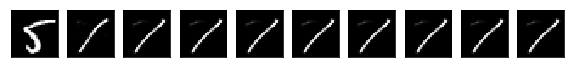

Test Image Name: 3557.jpg
100
200
300
400
500
600
700
800
900


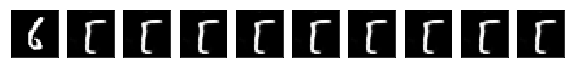

Test Image Name: 8480.jpg
100
200
300
400
500
600
700
800
900


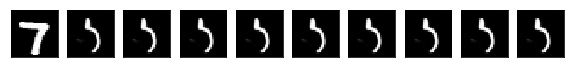

Test Image Name: 5513.jpg
100
200
300
400
500
600
700
800
900


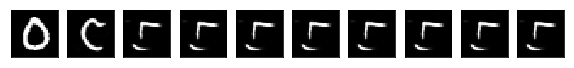

Test Image Name: 9482.jpg
100
200
300
400
500
600
700
800
900


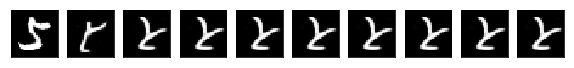

Test Image Name: 2757.jpg
100
200
300
400
500
600
700
800
900


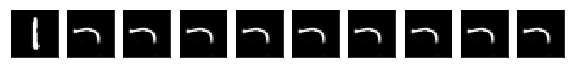

In [67]:
results_dir = 'results/superresolution/mnist/'
norm_diff = {}
for m in [2,3,4]:
    A = get_super_resol_A(m,dataset='mnist')
    y = np.zeros((10,int(28/m)**2))
    ctr = 0
    for i in x_test_task:
        y[ctr] = np.dot(A, x_test[i].flatten())
        ctr+=1


    iterations = 1000
    num_test = 10
    A_T = A.T
    norm_diff[m] = num_test*[0.]
    print("Using m={}".format(m))
    for i in range(num_test):
        print("Test Image Name: {}.jpg".format(x_test_task[i]))
        x_est, _ = estimate_ipt_mnist(A, A_T, y[i], autoencoder, iterations, visualize=True,x=x_test[x_test_task[i]])
        norm_diff[m][i] = np.linalg.norm(x_est.flatten() - x_test[x_test_task[i] ].flatten())
        im = Image.fromarray((x_est * 255).astype(np.uint8))
        im.save(results_dir + '{}/{}.png'.format(m,x_test_task[i]))
        
with open(results_dir + 'norm_diffs.pickle', 'wb') as handle:
    pickle.dump(norm_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Inpainting

In [15]:
x_test_task = [4598, 1337,  859, 4345, 8342, 9942, 6654, 7114, 3727, 5891]

Using m=5
Test Image Name: 4598.jpg


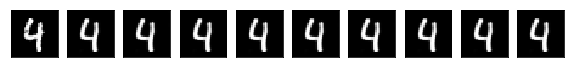

Test Image Name: 1337.jpg


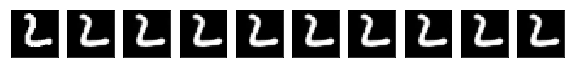

Test Image Name: 859.jpg


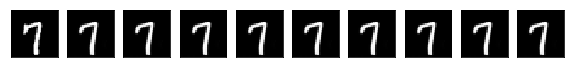

Test Image Name: 4345.jpg


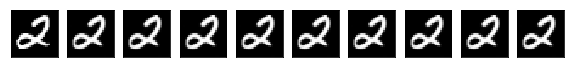

Test Image Name: 8342.jpg


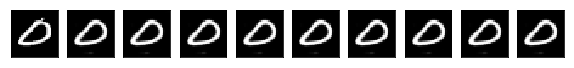

Test Image Name: 9942.jpg


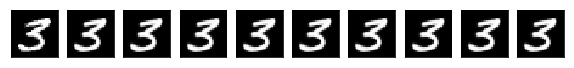

Test Image Name: 6654.jpg


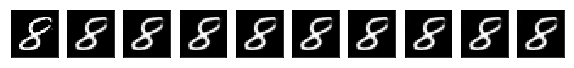

Test Image Name: 7114.jpg


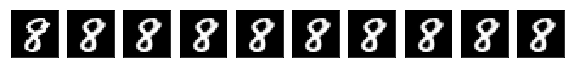

Test Image Name: 3727.jpg


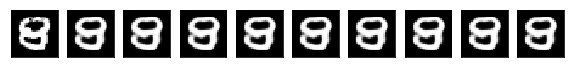

Test Image Name: 5891.jpg


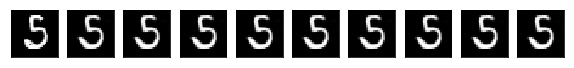

Using m=10
Test Image Name: 4598.jpg


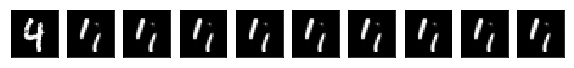

Test Image Name: 1337.jpg


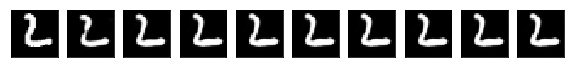

Test Image Name: 859.jpg


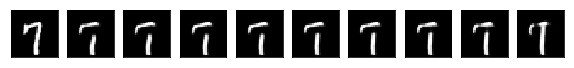

Test Image Name: 4345.jpg


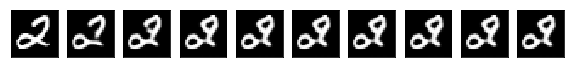

Test Image Name: 8342.jpg


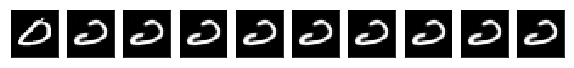

Test Image Name: 9942.jpg


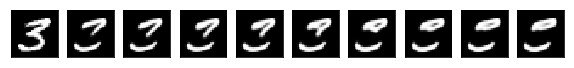

Test Image Name: 6654.jpg


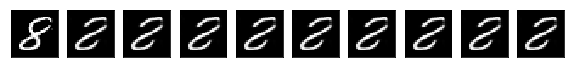

Test Image Name: 7114.jpg


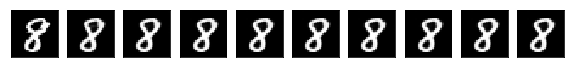

Test Image Name: 3727.jpg


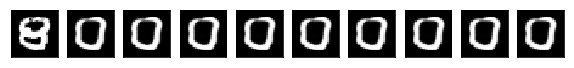

Test Image Name: 5891.jpg


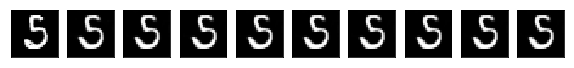

Using m=15
Test Image Name: 4598.jpg


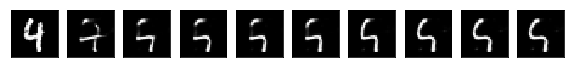

Test Image Name: 1337.jpg


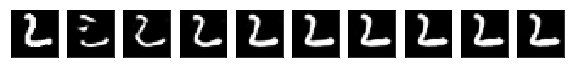

Test Image Name: 859.jpg


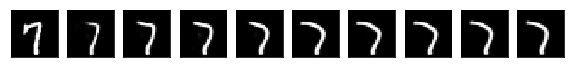

Test Image Name: 4345.jpg


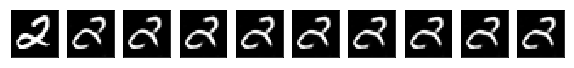

Test Image Name: 8342.jpg


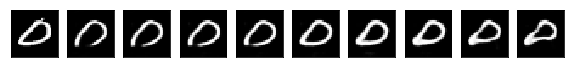

Test Image Name: 9942.jpg


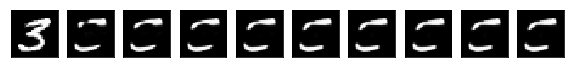

Test Image Name: 6654.jpg


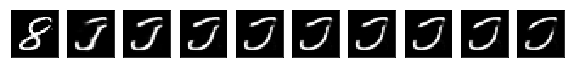

Test Image Name: 7114.jpg


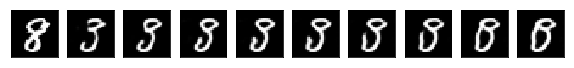

Test Image Name: 3727.jpg


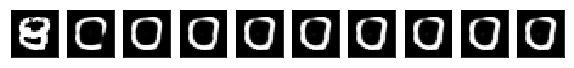

Test Image Name: 5891.jpg


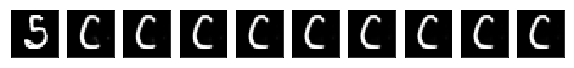

Using m=20
Test Image Name: 4598.jpg


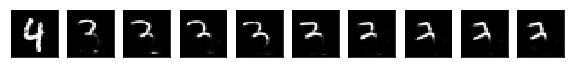

Test Image Name: 1337.jpg


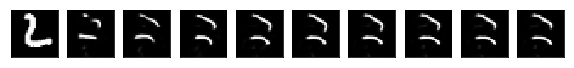

Test Image Name: 859.jpg


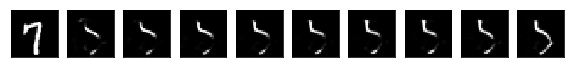

Test Image Name: 4345.jpg


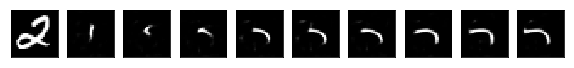

Test Image Name: 8342.jpg


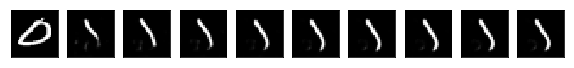

Test Image Name: 9942.jpg


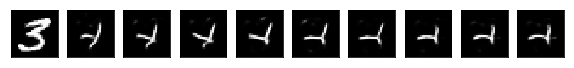

Test Image Name: 6654.jpg


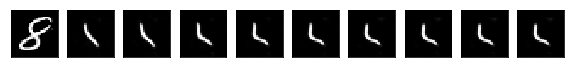

Test Image Name: 7114.jpg


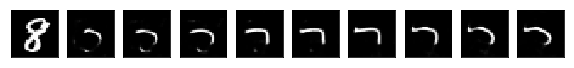

Test Image Name: 3727.jpg


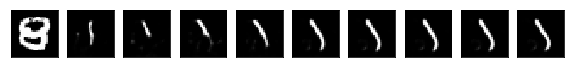

Test Image Name: 5891.jpg


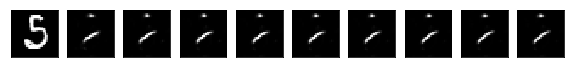

Using m=25
Test Image Name: 4598.jpg


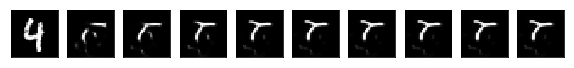

Test Image Name: 1337.jpg


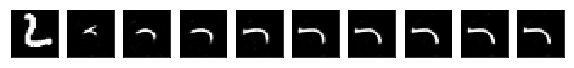

Test Image Name: 859.jpg


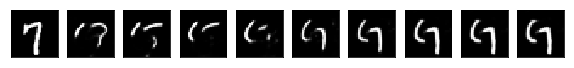

Test Image Name: 4345.jpg


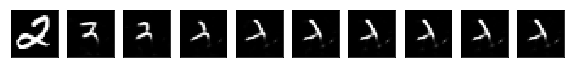

Test Image Name: 8342.jpg


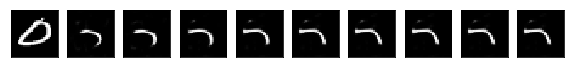

Test Image Name: 9942.jpg


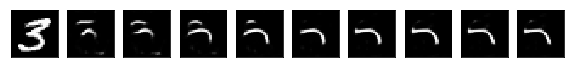

Test Image Name: 6654.jpg


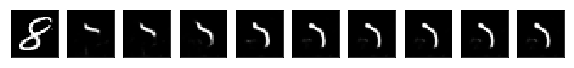

Test Image Name: 7114.jpg


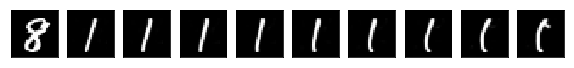

Test Image Name: 3727.jpg


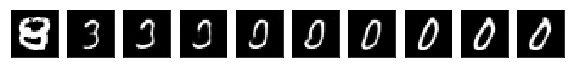

Test Image Name: 5891.jpg


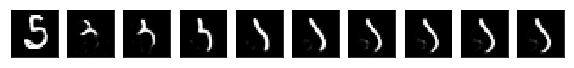

In [16]:
results_dir = 'results/inpainting/mnist/'
norm_diff = {}
for m in [5, 10,15, 20,25]:
    A = get_inpaint_A(m,dataset='mnist')
    y = np.zeros((10,784))
    ctr = 0
    for i in x_test_task:
        y[ctr] = np.dot(A, x_test[i].flatten())
        ctr+=1

    iterations = 50
    num_test = 10
    A_T = A.T
    norm_diff[m] = num_test*[0.]
    print("Using m={}".format(m))
    for i in range(num_test):
        print("Test Image Name: {}.jpg".format(x_test_task[i]))
        x_est, _ = estimate_ipt_mnist(A, A_T, y[i], autoencoder, iterations, visualize=True,x=x_test[x_test_task[i]])
        norm_diff[m][i] = np.linalg.norm(x_est.flatten() - x_test[x_test_task[i] ].flatten())
        im = Image.fromarray((x_est * 255).astype(np.uint8))
        im.save(results_dir + '{}/{}.png'.format(m,x_test_task[i]))
        
with open(results_dir + 'norm_diffs.pickle', 'wb') as handle:
    pickle.dump(norm_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)